# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg
from visual_evaluation import visualize
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
BENCHMARK = False

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'timegan_gru'

In [5]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

In [6]:
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)
df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,341988.000000,341988.000000,341988.000000,341988.000000,341988.000000
mean,3223.797936,282.704303,0.086439,0.000249,39.871618
std,1943.974204,12.922822,0.321004,0.000466,39.339560
min,41.627638,250.083873,0.000008,0.000000,0.016394
25%,1152.987320,270.511312,0.000130,0.000002,4.172619
50%,3608.409516,285.328962,0.000575,0.000006,15.465574
75%,5010.047921,293.711888,0.037928,0.000324,87.893841
max,7076.619110,305.881726,12.279954,0.004205,97.951007


In [7]:
data_real_df.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,28511.00000,28511.000000,28511.000000,28511.000000,28511.000000
mean,3313.74238,282.688768,0.061611,0.000250,42.122795
std,1971.53206,12.367361,0.678185,0.008298,39.316195
min,0.00000,243.390000,0.000000,0.000000,0.000000
25%,1289.00000,273.480000,0.000000,0.000000,1.000000
50%,3507.00000,284.550000,0.000000,0.000000,40.000000
75%,4948.00000,292.790000,0.000000,0.000000,90.000000
max,7280.00000,310.070000,42.000000,0.510000,100.000000


## 2 Train and Test Baseline Model

### Set Hyperparameters and Features

In [8]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [9]:
results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: True
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.10199262853711843
Training Loss: 0.08402628805488348
Training Loss: 0.07833742558956146
Validation Loss: 0.07435611108045899
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07408457271754741
Training Loss: 0.06993399219587446
Training Loss: 0.06793816968798637
Validation Loss: 0.06425129283177719
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06473458427935838
Training Loss: 0.0604521350748837
Training Loss: 0.057359250895679
Validation Loss: 0.05244566709472892
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05371174151077866
Training Loss: 0.04942636966705322
Training Loss: 0.04644702260382474
Validation Loss: 0.04223271612119808
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04411346809007227
Training Loss: 0.04046441118232906
Training Loss: 0

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive_evaluation.py:255: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [02:24<21:39, 144.42s/it]

Training Loss: 0.006553159552859142
Validation Loss: 0.003609617588664876
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.34632756136357784
Training Loss: 0.22463464479893447
Training Loss: 0.12611050479114055
Validation Loss: 0.06896612424863859
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06675982523709535
Training Loss: 0.058856510389596224
Training Loss: 0.056913510924205185
Validation Loss: 0.05413169150104683
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.056098900232464076
Training Loss: 0.05489537358283997
Training Loss: 0.0533230865560472
Validation Loss: 0.05065072955710165
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.052103646993637086
Training Loss: 0.050557338986545804
Training Loss: 0.04864014753140509
Validation Loss: 0.04593782204339344
Validation Acc

 20%|██        | 2/10 [04:48<19:11, 144.00s/it]

Training Loss: 0.005784288243739865
Validation Loss: 0.0028348166869660275
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.09211181225255131
Training Loss: 0.08016732340678573
Training Loss: 0.0760735577903688
Validation Loss: 0.07216128146045664
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07186104871332645
Training Loss: 0.06883921021595597
Training Loss: 0.06644560752436518
Validation Loss: 0.06332463306489955
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06354201966896653
Training Loss: 0.06080078672617674
Training Loss: 0.05821733731776476
Validation Loss: 0.055121714605039424
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05532151093706489
Training Loss: 0.052438004445284604
Training Loss: 0.04946853843517601
Validation Loss: 0.046378902295667136
Validation Accu

 30%|███       | 3/10 [07:12<16:47, 143.95s/it]

Training Loss: 0.006112957872683182
Validation Loss: 0.0031626235269889068
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8147700688242913
Training Loss: 0.6868951717019081
Training Loss: 0.5761230298876763
Validation Loss: 0.4233376511027304
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.36591543033719065
Training Loss: 0.2158388163521886
Training Loss: 0.12760248798877
Validation Loss: 0.08053772503070616
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07934648932889105
Training Loss: 0.06845047352835536
Training Loss: 0.06547759987413883
Validation Loss: 0.06271704273779741
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06438827434554696
Training Loss: 0.06334048956632614
Training Loss: 0.06261303890496492
Validation Loss: 0.06092678751336055
Validation Accuracy: 0.0


 40%|████      | 4/10 [09:40<14:35, 145.88s/it]

Validation Loss: 0.002950031646485493
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07558376705273986
Training Loss: 0.07065681286156178
Training Loss: 0.06753845121711492
Validation Loss: 0.06281784386112449
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0638774879463017
Training Loss: 0.06002741059288383
Training Loss: 0.05672417147085071
Validation Loss: 0.05185996527584751
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05195252595469355
Training Loss: 0.04737163686193526
Training Loss: 0.04339392286725342
Validation Loss: 0.038836954349882144
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03911838418804109
Training Loss: 0.035427022129297256
Training Loss: 0.03231033411808312
Validation Loss: 0.029316864541491097
Validation Accuracy: 0.0
***************************

 50%|█████     | 5/10 [12:04<12:05, 145.16s/it]

Validation Loss: 0.0031452830684674756
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.083650689329952
Training Loss: 0.06771085331216455
Training Loss: 0.06216930542141199
Validation Loss: 0.05686808327275716
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05949711887165904
Training Loss: 0.05728828437626362
Training Loss: 0.05476243180222809
Validation Loss: 0.05071439608680398
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.052230221210047605
Training Loss: 0.04958551281131804
Training Loss: 0.046364634111523625
Validation Loss: 0.042701850864994395
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04321717974729836
Training Loss: 0.040353442765772345
Training Loss: 0.03694651792757213
Validation Loss: 0.03414555230920904
Validation Accuracy: 0.0
**************************

 60%|██████    | 6/10 [14:29<09:39, 144.87s/it]

Training Loss: 0.006427442781860009
Validation Loss: 0.003410104278925011
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.26798152588307855
Training Loss: 0.19885919995605947
Training Loss: 0.16094094034284354
Validation Loss: 0.12803547578246405
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.12292787805199623
Training Loss: 0.10077107340097427
Training Loss: 0.09067443937063217
Validation Loss: 0.08044759385036619
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08185886304825545
Training Loss: 0.0757989864051342
Training Loss: 0.07404699081555009
Validation Loss: 0.07012015694145406
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0729564904421568
Training Loss: 0.07093473156914115
Training Loss: 0.07041286503896117
Validation Loss: 0.06713140186633956
Validation Accuracy:

 70%|███████   | 7/10 [16:53<07:14, 144.68s/it]

Training Loss: 0.005570669168955647
Validation Loss: 0.0025850258364729334
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 1.0431573012471198
Training Loss: 0.8483642387390137
Training Loss: 0.6774053634703159
Validation Loss: 0.3992738994989502
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.35830186530947683
Training Loss: 0.16594517067074777
Training Loss: 0.0759326915629208
Validation Loss: 0.050387346342708285
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05392378682270646
Training Loss: 0.0531953567173332
Training Loss: 0.05103387608192861
Validation Loss: 0.0493066142825933
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04801411834545433
Training Loss: 0.047535320948809384
Training Loss: 0.045384111842140556
Validation Loss: 0.043779613366455174
Validation Accuracy:

 80%|████████  | 8/10 [19:17<04:49, 144.50s/it]

Validation Loss: 0.0026845951575074304
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.9927098450064659
Training Loss: 0.8001877436041832
Training Loss: 0.6080434013903141
Validation Loss: 0.3625912612743592
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.2964773453772068
Training Loss: 0.12874269291758536
Training Loss: 0.0683278595842421
Validation Loss: 0.055238860627908386
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05534841182641685
Training Loss: 0.05269849769771099
Training Loss: 0.049827968245372174
Validation Loss: 0.047580989935759745
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04663891536183655
Training Loss: 0.04414660841226578
Training Loss: 0.04132935860194266
Validation Loss: 0.039144813909791826
Validation Accuracy: 0.0
******************************

 90%|█████████ | 9/10 [21:42<02:24, 144.55s/it]

Validation Loss: 0.0031331388209161633
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7690548077225685
Training Loss: 0.6768567396700382
Training Loss: 0.5859637203812599
Validation Loss: 0.4407129086805194
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.378937850818038
Training Loss: 0.23865098536014556
Training Loss: 0.15355184562504293
Validation Loss: 0.09887669662411293
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.09281455721706151
Training Loss: 0.0736551882699132
Training Loss: 0.06673333356156945
Validation Loss: 0.061124079180567455
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06367906380444766
Training Loss: 0.06200961561873555
Training Loss: 0.06111976688727736
Validation Loss: 0.05839388809177313
Validation Accuracy: 0.0
**********************************

100%|██████████| 10/10 [24:06<00:00, 144.61s/it]


Training Loss: 0.005318960766890086
Validation Loss: 0.0025407699894243745
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.3055683656036854
Training Loss: 0.24367969498038292
Training Loss: 0.187581084407866
Validation Loss: 0.13870349145504865
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.10986102377995849
Training Loss: 0.07665969228371977
Training Loss: 0.0630116830393672
Validation Loss: 0.05958155144968729
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058190427403897044
Training Loss: 0.05579065116122365
Training Loss: 0.05230004083365202
Validation Loss: 0.05017950025837073
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.048998719435185197
Training Loss: 0.04674005984328687
Training Loss: 0.04312021322548389
Validation Loss: 0.04072731052096305
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.03946921659633517
Training Loss: 0.0373997522611171
Training Loss: 0

 10%|█         | 1/10 [02:28<22:13, 148.18s/it]

Training Loss: 0.005852743376162834
Validation Loss: 0.003574235923980687
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07613000363111495
Training Loss: 0.07613427693024277
Training Loss: 0.07320532290264964
Validation Loss: 0.07384298316966952
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07103952635079622
Training Loss: 0.07089536776766181
Training Loss: 0.06756719382479787
Validation Loss: 0.06706139466233468
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06404928224161267
Training Loss: 0.06294459767639637
Training Loss: 0.05850902885198593
Validation Loss: 0.05606923278504878
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05300026459619403
Training Loss: 0.05088964574038982
Training Loss: 0.04557477476075292
Validation Loss: 0.04155977741093113
Validation Accurac

 20%|██        | 2/10 [04:55<19:43, 147.96s/it]

Training Loss: 0.005834419308230281
Validation Loss: 0.0036699957995194148
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1180068145878613
Training Loss: 0.08431596156209707
Training Loss: 0.06484818087890744
Validation Loss: 0.0578319588885381
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05506870672106743
Training Loss: 0.053028168240562085
Training Loss: 0.05006391951814294
Validation Loss: 0.04915452883526515
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.047489403691142795
Training Loss: 0.04622206988744438
Training Loss: 0.04318638413213193
Validation Loss: 0.041616462704756954
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03991013888269663
Training Loss: 0.03817696137353778
Training Loss: 0.03457624957896769
Validation Loss: 0.03168163952951351
Validation Accur

 30%|███       | 3/10 [07:23<17:13, 147.66s/it]

Training Loss: 0.005912080055568367
Validation Loss: 0.0037126061598132
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.48552556470036506
Training Loss: 0.3761254795640707
Training Loss: 0.28658098690211775
Validation Loss: 0.2129897761964396
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1814253880828619
Training Loss: 0.13536935448646545
Training Loss: 0.10659669924527407
Validation Loss: 0.09095599460467864
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08320021329447627
Training Loss: 0.07568720007315279
Training Loss: 0.07036074118688702
Validation Loss: 0.07026686856334799
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06757243925705553
Training Loss: 0.06770254680886864
Training Loss: 0.06567368809133768
Validation Loss: 0.06705269200748272
Validation Accuracy: 0.

 40%|████      | 4/10 [09:51<14:46, 147.77s/it]

Training Loss: 0.006190799527103081
Validation Loss: 0.003944485297222527
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.832345781326294
Training Loss: 0.7183354651927948
Training Loss: 0.5964113886654377
Validation Loss: 0.4616024176056465
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.38918513879179956
Training Loss: 0.26409964308142664
Training Loss: 0.16907556485384703
Validation Loss: 0.10566939735847912
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.08500321174040437
Training Loss: 0.06601974818855524
Training Loss: 0.06049061117693782
Validation Loss: 0.060250855176552626
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05889851303771138
Training Loss: 0.0584672855772078
Training Loss: 0.05631170907989144
Validation Loss: 0.05618166035103999
Validation Accuracy: 0.

 50%|█████     | 5/10 [12:18<12:18, 147.67s/it]

Validation Loss: 0.004267253013055646
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.7149092358350754
Training Loss: 0.6260455949604511
Training Loss: 0.5524989366531372
Validation Loss: 0.4860157645150517
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.4370061731338501
Training Loss: 0.3500999034941196
Training Loss: 0.27304128773510455
Validation Loss: 0.21072190455841214
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.17770062282681465
Training Loss: 0.1325483561307192
Training Loss: 0.10251040985807776
Validation Loss: 0.08640741939876187
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0776201855763793
Training Loss: 0.0695052550546825
Training Loss: 0.06385358216241002
Validation Loss: 0.06322970078065154
Validation Accuracy: 0.0
**************************************

 60%|██████    | 6/10 [14:46<09:50, 147.66s/it]

Training Loss: 0.005825647198362276
Validation Loss: 0.0036929506557376196
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5768126215040684
Training Loss: 0.40265481643378737
Training Loss: 0.2623634819686413
Validation Loss: 0.15153466319937384
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.11451097432523966
Training Loss: 0.07465025030076504
Training Loss: 0.06076362451538444
Validation Loss: 0.05885077460428302
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.056144591215997935
Training Loss: 0.055608337484300135
Training Loss: 0.052865951973944905
Validation Loss: 0.05305072091770976
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05051992087624967
Training Loss: 0.049978193445131186
Training Loss: 0.04705771711654961
Validation Loss: 0.0468594908735223
Validation Accur

 70%|███████   | 7/10 [17:14<07:23, 147.67s/it]

Validation Loss: 0.004068181543281365
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8926534813642502
Training Loss: 0.7626915383338928
Training Loss: 0.6389442871510983
Validation Loss: 0.4974626972434226
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.43622893691062925
Training Loss: 0.3085964596271515
Training Loss: 0.20706436987966298
Validation Loss: 0.12701775397310097
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.10533810019493103
Training Loss: 0.07790129009634256
Training Loss: 0.0672131204791367
Validation Loss: 0.06536537094899778
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06308170495554805
Training Loss: 0.06280057448893786
Training Loss: 0.060970090143382547
Validation Loss: 0.062081878376978164
Validation Accuracy: 0.0
*********************************

 80%|████████  | 8/10 [19:41<04:55, 147.60s/it]

Training Loss: 0.006294754554983228
Validation Loss: 0.004035994587099871
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.38677580282092094
Training Loss: 0.31131463304162027
Training Loss: 0.2624236987531185
Validation Loss: 0.2282540672197101
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.20670260343700647
Training Loss: 0.1670379015058279
Training Loss: 0.1298924532905221
Validation Loss: 0.10253621560385388
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0893015318736434
Training Loss: 0.07711978057399392
Training Loss: 0.07156962996348738
Validation Loss: 0.07254471548236488
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06983397444710135
Training Loss: 0.06980931792408228
Training Loss: 0.06757872914895416
Validation Loss: 0.06918952794054921
Validation Accuracy: 0.

 90%|█████████ | 9/10 [22:09<02:27, 147.66s/it]

Training Loss: 0.006058036473114044
Validation Loss: 0.0037653324759324616
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2759816474467516
Training Loss: 0.20526028349995612
Training Loss: 0.1473996115475893
Validation Loss: 0.10805746963184872
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.09302838683128357
Training Loss: 0.07914889071136713
Training Loss: 0.07277359556406736
Validation Loss: 0.0732222024686216
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0700938049517572
Training Loss: 0.07035664720460773
Training Loss: 0.06766133582219482
Validation Loss: 0.06863472725819336
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.065641536898911
Training Loss: 0.06568525183945895
Training Loss: 0.06272672241553665
Validation Loss: 0.06306709311483952
Validation Accuracy: 0.

100%|██████████| 10/10 [24:36<00:00, 147.68s/it]

Training Loss: 0.006027296919492073
Validation Loss: 0.0038383750367930597
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.07992527563124895
Training Loss: 0.06660566832870245
Training Loss: 0.062209044490009545
Validation Loss: 0.05830317169594365
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.056382692754268646
Training Loss: 0.05063044060021639
Training Loss: 0.046655063843354584
Validation Loss: 0.04230732909877207
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.039633853500708936
Training Loss: 0.03347479964606464
Training Loss: 0.029017339898273348
Validation Loss: 0.025263606591472747
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.022922828211449087
Training Loss: 0.019003536733798683
Training Loss: 0.01683933424530551
Validation Loss: 0.015779234403900427
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.014529779872391372
Training Loss: 0.012816807185299695
Tr

 10%|█         | 1/10 [02:27<22:08, 147.63s/it]

Training Loss: 0.0014713440447667381
Validation Loss: 0.0016099172949988665
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0889636379852891
Training Loss: 0.06870028452947735
Training Loss: 0.06199571730569005
Validation Loss: 0.058136211052620214
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05528949718922377
Training Loss: 0.048763206638395784
Training Loss: 0.04377779391594231
Validation Loss: 0.04072195760822496
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.038076400151476265
Training Loss: 0.03292038348503411
Training Loss: 0.029025424169376493
Validation Loss: 0.026872936474918986
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.024726277529262007
Training Loss: 0.020944941425696015
Training Loss: 0.018412742600776254
Validation Loss: 0.01710968815289729
Validatio

 20%|██        | 2/10 [04:55<19:41, 147.64s/it]

Training Loss: 0.0014020877969596768
Validation Loss: 0.0015819156639975127
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07198464412242174
Training Loss: 0.06679467804729938
Training Loss: 0.06395847931504249
Validation Loss: 0.06198975433434188
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06031859612092376
Training Loss: 0.05473970047198236
Training Loss: 0.048359066667035225
Validation Loss: 0.04113853901791173
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03650049111805856
Training Loss: 0.028866708520799877
Training Loss: 0.024313340689986945
Validation Loss: 0.022776376029382872
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.021065065963193776
Training Loss: 0.018927554273977874
Training Loss: 0.016974708072375506
Validation Loss: 0.016671894409553297
Validati

 30%|███       | 3/10 [07:22<17:12, 147.56s/it]

Validation Loss: 0.0015401407711594184
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11280116816982627
Training Loss: 0.09510654168203474
Training Loss: 0.08760345721617341
Validation Loss: 0.08229591060617117
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08099174041301012
Training Loss: 0.07579297015443444
Training Loss: 0.0728723219782114
Validation Loss: 0.07050455815299263
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06924926148727537
Training Loss: 0.06464798090979457
Training Loss: 0.060749811232089994
Validation Loss: 0.05787757730017827
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05559299250133336
Training Loss: 0.050415408704429863
Training Loss: 0.045608513569459316
Validation Loss: 0.043394703241117175
Validation Accuracy: 0.0
*************************

 40%|████      | 4/10 [09:50<14:45, 147.54s/it]

Training Loss: 0.001427521956647979
Validation Loss: 0.001605463034067532
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5996211493015289
Training Loss: 0.4803561036288738
Training Loss: 0.3642565260082483
Validation Loss: 0.24308485995624318
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1968013057112694
Training Loss: 0.12440034007653594
Training Loss: 0.09198714524507523
Validation Loss: 0.07858427840820904
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0758312296308577
Training Loss: 0.06969866000115871
Training Loss: 0.0676877973228693
Validation Loss: 0.06732163336856405
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06658595772460103
Training Loss: 0.06255212435498833
Training Loss: 0.05988350734114647
Validation Loss: 0.057548062553285886
Validation Accuracy: 0.

 50%|█████     | 5/10 [12:17<12:17, 147.48s/it]

Training Loss: 0.0014204513466393109
Validation Loss: 0.0015636096453127014
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.8977389597892761
Training Loss: 0.7575143826007843
Training Loss: 0.6141864064335824
Validation Loss: 0.4517224960486982
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.38099547669291495
Training Loss: 0.24906123064458371
Training Loss: 0.16930004805326462
Validation Loss: 0.12361207179850041
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.11207066625356674
Training Loss: 0.09201337087899447
Training Loss: 0.08423484960570932
Validation Loss: 0.08001883513184899
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.07904790043830871
Training Loss: 0.07437712168321013
Training Loss: 0.07352516017854213
Validation Loss: 0.07238958282760402
Validation Accuracy:

 60%|██████    | 6/10 [14:44<09:48, 147.23s/it]

Training Loss: 0.0012758745056635234
Validation Loss: 0.0014406422497971274
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.17414649698883294
Training Loss: 0.09564738949760794
Training Loss: 0.0647554892860353
Validation Loss: 0.05634038279342918
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.053875252278521656
Training Loss: 0.047103981617838145
Training Loss: 0.043245775448158386
Validation Loss: 0.03940254898336014
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03667198380455375
Training Loss: 0.03108856455422938
Training Loss: 0.027702086265198888
Validation Loss: 0.02555467533311864
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02372971149161458
Training Loss: 0.021264007878489793
Training Loss: 0.019784563747234644
Validation Loss: 0.019502234288787876
Validation

 70%|███████   | 7/10 [17:11<07:21, 147.22s/it]

Validation Loss: 0.0015181159962706174
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.08212583320215344
Training Loss: 0.07502114774659276
Training Loss: 0.07051142750307918
Validation Loss: 0.06738597687396257
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0653241484798491
Training Loss: 0.05998068923130631
Training Loss: 0.05422102231532335
Validation Loss: 0.05059394026019054
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.047637395691126586
Training Loss: 0.04310228996910155
Training Loss: 0.03794989374466241
Validation Loss: 0.03589670296612731
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.033467130712233485
Training Loss: 0.03060708985198289
Training Loss: 0.02675723663996905
Validation Loss: 0.02541137789506153
Validation Accuracy: 0.0
***************************

 80%|████████  | 8/10 [19:38<04:54, 147.22s/it]

Validation Loss: 0.0015465514249865529
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07144896790385247
Training Loss: 0.06679377818480134
Training Loss: 0.06301127834245562
Validation Loss: 0.06049605458974838
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05847989929839969
Training Loss: 0.05296257149428129
Training Loss: 0.04733489543199539
Validation Loss: 0.0429726833758574
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.039869753271341325
Training Loss: 0.03394067743327469
Training Loss: 0.02927296744659543
Validation Loss: 0.026664758860731923
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.024206340992823244
Training Loss: 0.020749048935249446
Training Loss: 0.018125093481503426
Validation Loss: 0.017297818538779652
Validation Accuracy: 0.0
***********************

 90%|█████████ | 9/10 [22:05<02:27, 147.10s/it]

Validation Loss: 0.0015444042854233485
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11499104015529156
Training Loss: 0.09728339029476046
Training Loss: 0.08838980447500944
Validation Loss: 0.08491167781989002
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08277883769944311
Training Loss: 0.0766072309948504
Training Loss: 0.07216481376439333
Validation Loss: 0.07034745620948642
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06863710753619671
Training Loss: 0.06359043316915632
Training Loss: 0.0596134215965867
Validation Loss: 0.05727543931600102
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.054961259784176944
Training Loss: 0.04903982509858906
Training Loss: 0.04419524665921926
Validation Loss: 0.040821919238517405
Validation Accuracy: 0.0
****************************

100%|██████████| 10/10 [24:32<00:00, 147.25s/it]

Training Loss: 0.0013604873295116704
Validation Loss: 0.0015201294134070515
Validation Accuracy: 0.0
**************************************************


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 1.0231217512488364
Training Loss: 0.8196264472603798
Training Loss: 0.6521985119581223
Training Loss: 0.43292597115039827
Training Loss: 0.2266335841268301
Training Loss: 0.11081467483192682
Training Loss: 0.0748412263393402
Validation Loss: 0.06625952175382371
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0669085798971355
Training Loss: 0.061234310176223515
Training Loss: 0.05917148943990469
Training Loss: 0.057634489070624115
Training Loss: 0.05315632771700621
Training Loss: 0.049708403935655954
Training Loss: 0.04781501671299338
Validation Loss: 0.049522186437628686
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05485344775021076
Training Loss: 0.05338363841176033
Training Loss: 0.05205040573142469
Training Loss: 0.04654160035774112
Training Loss: 0.03714823277667165
Training Loss: 0.033114441717043516
Training Loss: 0.03007704113610089
Validation Lo

 10%|█         | 1/10 [04:47<43:11, 287.92s/it]

Training Loss: 0.0018712436869100203
Validation Loss: 0.002800990760453701
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.9094585567712784
Training Loss: 0.7889236935973167
Training Loss: 0.6696822735667228
Training Loss: 0.4583181761205196
Training Loss: 0.20015674360096455
Training Loss: 0.07689038066193461
Training Loss: 0.05985496418550611
Validation Loss: 0.05789126762736602
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06236792268231511
Training Loss: 0.06044696532189846
Training Loss: 0.05866334974765777
Training Loss: 0.05454073961824179
Training Loss: 0.0460773045476526
Training Loss: 0.040882760593667626
Training Loss: 0.03798023047856987
Validation Loss: 0.04119152104140221
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.050556312277913094
Training Loss: 0.04811109816655516
Training Loss: 0.04658744118176401
Trai

 20%|██        | 2/10 [09:35<38:23, 287.94s/it]

Training Loss: 0.001721906455932185
Validation Loss: 0.0029294646775859237
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.16377155907452107
Training Loss: 0.1325274835526943
Training Loss: 0.11239703349769116
Training Loss: 0.09734712682664394
Training Loss: 0.08981982277706266
Training Loss: 0.0833884809166193
Training Loss: 0.08202516309916973
Validation Loss: 0.07833131476678652
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07868308102712035
Training Loss: 0.07627312818542123
Training Loss: 0.07338418221101164
Training Loss: 0.0754568818025291
Training Loss: 0.07425301540642977
Training Loss: 0.0715178088285029
Training Loss: 0.07141699632629753
Validation Loss: 0.0700002790529853
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07170399585738778
Training Loss: 0.07007109636440872
Training Loss: 0.06769399357959628
Traini

 30%|███       | 3/10 [13:35<31:02, 266.09s/it]

Training Loss: 0.001868821345124161
Validation Loss: 0.003015806771704076
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 167
Early stopping after 167 epochs
Epoch: 1
Training Loss: 0.48091809287667275
Training Loss: 0.3454923276603222
Training Loss: 0.21932273026555776
Training Loss: 0.12002153985202313
Training Loss: 0.08316421521827579
Training Loss: 0.07044047959148884
Training Loss: 0.06682632053270936
Validation Loss: 0.06495187286468927
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0673003483004868
Training Loss: 0.06458379097282886
Training Loss: 0.06254600526764989
Training Loss: 0.06287241725251079
Training Loss: 0.06041059501469135
Training Loss: 0.05820743966847658
Training Loss: 0.057588095925748345
Validation Loss: 0.05710576968581489
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06032095167785883
Training Loss: 0.058419652357697485
Train

 40%|████      | 4/10 [18:24<27:28, 274.83s/it]

Validation Loss: 0.0029456561775956553
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.29198069393634796
Training Loss: 0.21844413358718157
Training Loss: 0.17196291014552118
Training Loss: 0.13041722260415553
Training Loss: 0.10037790130823851
Training Loss: 0.08143536953255534
Training Loss: 0.07218499910086393
Validation Loss: 0.06706798057096282
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0676816001534462
Training Loss: 0.061921351589262486
Training Loss: 0.05879141235724092
Training Loss: 0.057953748609870674
Training Loss: 0.05465434109792113
Training Loss: 0.051094279382377865
Training Loss: 0.04851913470774889
Validation Loss: 0.04657101222359286
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.049494125433266166
Training Loss: 0.04653230735100806
Training Loss: 0.04396240168251097
Training Loss: 0.03942276139743626

 50%|█████     | 5/10 [23:12<23:18, 279.62s/it]

Validation Loss: 0.0026421840386578557
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.088288793284446
Training Loss: 0.07449412256479264
Training Loss: 0.06823433216661215
Training Loss: 0.0672201480716467
Training Loss: 0.06388472750782967
Training Loss: 0.059518629889935254
Training Loss: 0.05687415264546871
Validation Loss: 0.05508766109158707
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05602383704856038
Training Loss: 0.05194108687341213
Training Loss: 0.048035024367272854
Training Loss: 0.04337881441228092
Training Loss: 0.03619099020957947
Training Loss: 0.03034430601634085
Training Loss: 0.026207933025434612
Validation Loss: 0.026460771462862635
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.029787514898926018
Training Loss: 0.025280509376898408
Training Loss: 0.023130133198574186
Training Loss: 0.0168234470835886

 60%|██████    | 6/10 [28:00<18:50, 282.62s/it]

Training Loss: 0.001954923225857783
Validation Loss: 0.0028773932526985095
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.39587141916155816
Training Loss: 0.26019978314638137
Training Loss: 0.15610485542565583
Training Loss: 0.09645051380619407
Training Loss: 0.07442782690748573
Training Loss: 0.0657560564763844
Training Loss: 0.06462234219536185
Validation Loss: 0.0616923515172152
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.062326538413763045
Training Loss: 0.06019241465255618
Training Loss: 0.057947502471506596
Training Loss: 0.057318280506879093
Training Loss: 0.05377035924233496
Training Loss: 0.0488218320067972
Training Loss: 0.045837236680090425
Validation Loss: 0.04405776478266448
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04747151823714375
Training Loss: 0.04448699735105038
Training Loss: 0.04259583476930857


 70%|███████   | 7/10 [28:38<10:07, 202.47s/it]

Validation Loss: 0.00310672679207504
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 26
Early stopping after 26 epochs
Epoch: 1
Training Loss: 0.2403056463599205
Training Loss: 0.16754007540643215
Training Loss: 0.12305280059576035
Training Loss: 0.08805985709652304
Training Loss: 0.067561204880476
Training Loss: 0.05955919804051518
Training Loss: 0.05686348896473646
Validation Loss: 0.056915779880593334
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06091136319562793
Training Loss: 0.05843000657856465
Training Loss: 0.05571680646389723
Training Loss: 0.05199250657111407
Training Loss: 0.0448374464828521
Training Loss: 0.040493698036298154
Training Loss: 0.03697828470729291
Validation Loss: 0.038332612954833534
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0450583144556731
Training Loss: 0.0421808557678014
Training Loss: 0.03979142786003649
Training Los

 80%|████████  | 8/10 [33:27<07:40, 230.07s/it]

Validation Loss: 0.0028498696018540567
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07355542032048107
Training Loss: 0.07023056704550981
Training Loss: 0.06696089416742325
Training Loss: 0.06741316627711058
Training Loss: 0.0637985622510314
Training Loss: 0.059179480262100695
Training Loss: 0.05653372971341014
Validation Loss: 0.05551238400575597
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.058724975641816855
Training Loss: 0.05612587478011846
Training Loss: 0.053460107296705243
Training Loss: 0.04944311832077801
Training Loss: 0.04165434828959405
Training Loss: 0.036718535926193
Training Loss: 0.03368553267791867
Validation Loss: 0.03638506281688419
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.043988704876974226
Training Loss: 0.04148918163962662
Training Loss: 0.0399189427588135
Training Loss: 0.03235301178880036
Tr

 90%|█████████ | 9/10 [34:29<02:57, 177.52s/it]

Training Loss: 0.0019970799540169537
Validation Loss: 0.003102108366479609
Validation Accuracy: 0.0
INFO: Validation loss did not improve in epoch 43
Early stopping after 43 epochs
Epoch: 1
Training Loss: 0.5863264471292495
Training Loss: 0.45259485244750974
Training Loss: 0.33687908880412576
Training Loss: 0.21802668519318102
Training Loss: 0.13896517315879464
Training Loss: 0.09895189383998514
Training Loss: 0.0862448750063777
Validation Loss: 0.0782498267064157
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07751297632232308
Training Loss: 0.07296927528455853
Training Loss: 0.06993228893727065
Training Loss: 0.07105317492038012
Training Loss: 0.0687360705062747
Training Loss: 0.06361008055508137
Training Loss: 0.061814161334186796
Validation Loss: 0.06011278211568179
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.060604404304176566
Training Loss: 0.05744345249608159
Training

100%|██████████| 10/10 [39:18<00:00, 235.81s/it]

Training Loss: 0.0019229074427857995
Validation Loss: 0.0027793657729203365
Validation Accuracy: 0.0
**************************************************


In [10]:
results.shape

(80, 3)

In [11]:
results.to_csv(DATA_FOLDER / f"results/results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}.csv", index=False)

In [12]:
mse_results = results.loc[results['Metric'] == 'MSE']
mae_results = results.loc[results['Metric'] == 'MAE']

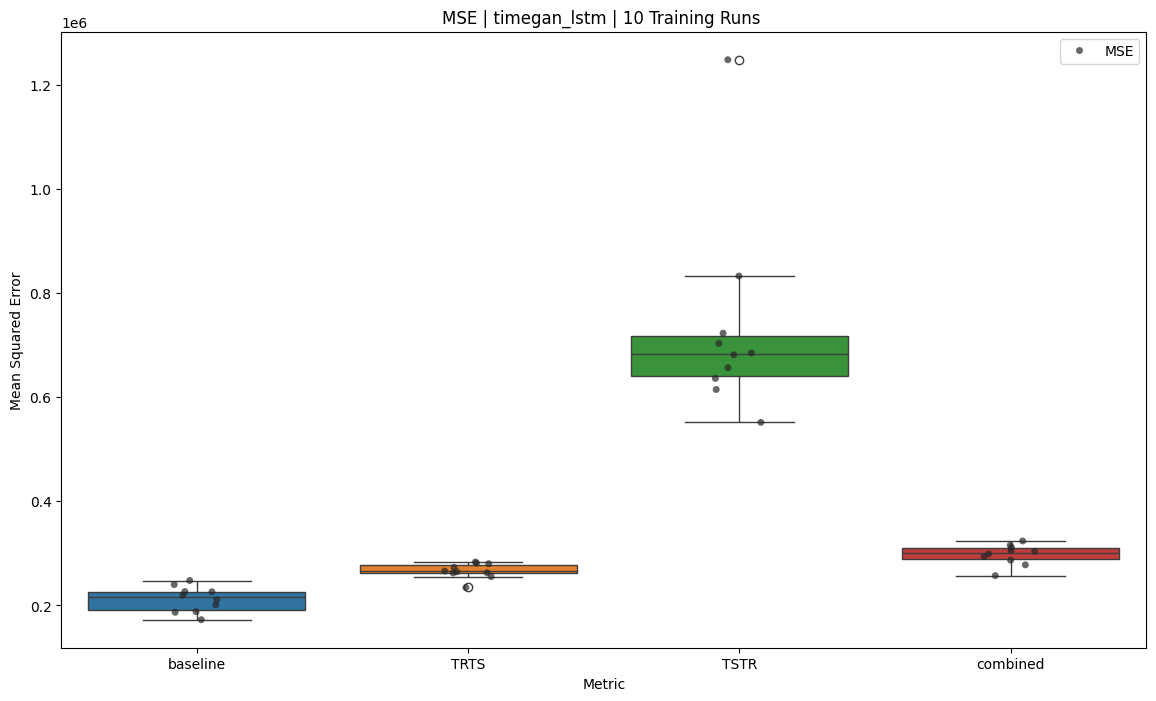

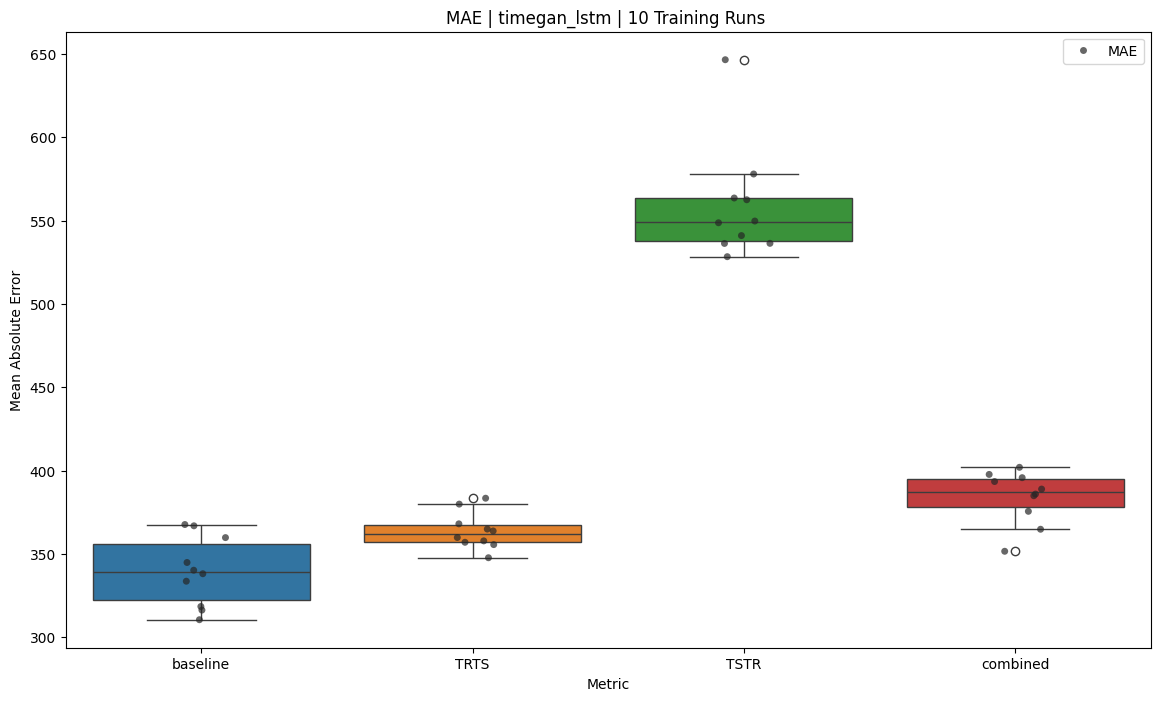

In [13]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

## 3 Evaluate Similarity of Synthetic vs Real Data

## 4 Visualize Synthetic vs Real Data

In [14]:
# split data before feeding into visual evaluation
data_real_seq = split_data_into_sequences(data_real_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

if data_syn_numpy.ndim == 3:
    data_syn_seq = data_syn_numpy
else:
    data_syn_seq = split_data_into_sequences(data_syn_numpy, seq_len=hyperparameters['seq_len'], shuffle_data=True)

Shape of the data after splitting into sequences: (28500, 12, 5)


Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)


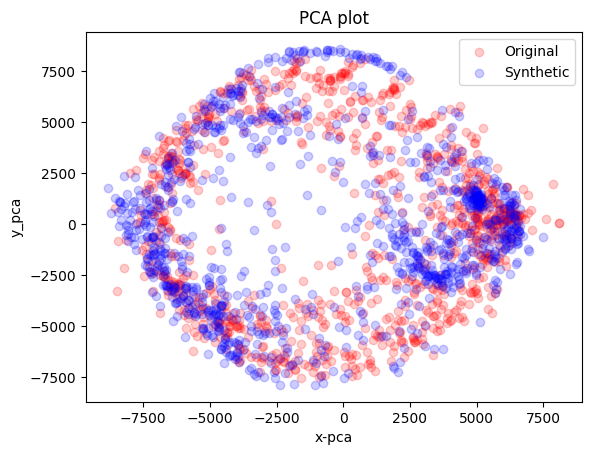

Preprocessing data. Shape: (28500, 12, 5)
Data has been preprocessed. Shape: (1000, 60)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...


c:\Users\fanny\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 2000 samples in 0.096s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1262.118284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.708912
[t-SNE] KL divergence after 300 iterations: 1.108704


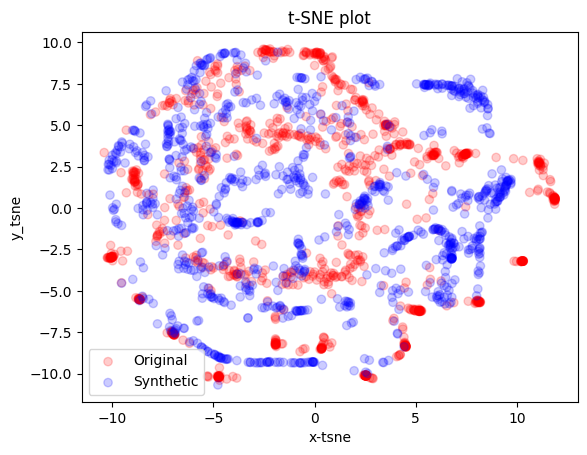

In [15]:
visualize(data_real_seq, data_syn_seq, metric='pca')
visualize(data_real_seq, data_syn_seq, metric='tsne')

### Beispielaussage:
PCA-Analyse von Realen und Synthetischen Daten
Um die Ähnlichkeit zwischen den realen und synthetischen Daten zu bewerten, wurde eine Principal Component Analysis (PCA) durchgeführt. Die PCA reduziert die Dimensionalität der Daten und projiziert sie auf eine zweidimensionale Ebene, wobei die Hauptkomponenten beibehalten werden, die den größten Teil der Varianz erklären.

Abbildung X zeigt den PCA-Plot der realen (rote Punkte) und synthetischen Daten (blaue Punkte). Die folgenden Beobachtungen können gemacht werden:

Verteilung und Clusterbildung:

Die roten Punkte, die die realen Daten repräsentieren, sind in einem spezifischen Bereich konzentriert.
Die blauen Punkte, die die synthetischen Daten darstellen, zeigen eine größere Verteilung und decken einen breiteren Bereich ab.
Ähnlichkeit und Unterschiede:

Die Tatsache, dass die synthetischen Daten eine größere Variabilität aufweisen, könnte darauf hinweisen, dass sie eine breitere Vielfalt an Mustern generieren.
Die Cluster der realen und synthetischen Daten überlappen sich teilweise, was darauf hindeutet, dass die synthetischen Daten einige der Eigenschaften der realen Daten gut nachahmen. Allerdings gibt es auch Bereiche, in denen die synthetischen Daten stark von den realen Daten abweichen, was auf Unterschiede in den zugrunde liegenden Verteilungen hinweist.
Schlussfolgerung:

Die PCA-Analyse zeigt, dass die synthetischen Daten in gewissem Maße die Struktur der realen Daten einfangen, jedoch eine größere Variabilität aufweisen.
Weitere Untersuchungen und Anpassungen am Generierungsprozess der synthetischen Daten könnten notwendig sein, um deren Genauigkeit und Übereinstimmung mit den realen Daten zu verbessern.